# Import libraries and reduced datasets

In [371]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import pandas_profiling
import pickle
import os

from sklearn.preprocessing import MinMaxScaler

# Import libraries for xgboost
import xgboost as xgb
from xgboost import cv
from sklearn import metrics  

# Import libraries for adboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import RepeatedStratifiedKFold

#from scipy import stats


os.getcwd()

'/Users/valentyna/Documents'

In [372]:
#read datasets
credit_card = pd.read_csv('credit_card.csv')
small_business = pd.read_csv('small_business.csv')

# remove index column that was stored after reset_index
credit_card = credit_card.iloc[: , 1:]
small_business = small_business.iloc[: , 1:]

credit_card.head()

,acc_now_delinq,addr_state,all_util,annual_inc_joint,annual_inc,application_type,avg_cur_bal,delinq_amnt,dti_joint,dti,...,revol_bal,revol_util,sub_grade,term,title,tot_cur_bal,total_rev_hi_lim,total_acc,verification_status,zip_code
0,0.0,PA,46.0,NaN,85000.0,Individual,1997.0,0.0,NaN,13.07,...,10464.0,34.5,A2,36 months,Credit card refinancing,27957.0,30300.0,23.0,Not Verified,160xx
1,0.0,RI,49.0,NaN,42000.0,Individual,28528.0,0.0,NaN,34.80,...,7034.0,39.1,B5,36 months,Credit card refinancing,199696.0,18000.0,18.0,Not Verified,029xx
2,0.0,SC,50.0,NaN,60000.0,Individual,7912.0,0.0,NaN,22.44,...,7722.0,59.4,A4,36 months,Credit card refinancing,55387.0,13000.0,9.0,Not Verified,299xx
3,0.0,NY,68.0,NaN,64000.0,Individual,3549.0,0.0,NaN,18.28,...,24940.0,52.7,B1,60 months,Credit card refinancing,63886.0,47300.0,33.0,Not Verified,117xx
4,0.0,SC,65.0,NaN,48000.0,Individual,2848.0,0.0,NaN,33.18,...,19108.0,29.6,C5,60 months,Credit card refinancing,31329.0,284700.0,19.0,Not Verified,297xx


In [373]:
small_business.head()

,acc_now_delinq,addr_state,all_util,annual_inc_joint,annual_inc,application_type,avg_cur_bal,delinq_amnt,dti_joint,dti,...,revol_bal,revol_util,sub_grade,term,title,tot_cur_bal,total_rev_hi_lim,total_acc,verification_status,zip_code
0,0.0,SD,29.0,NaN,65000.0,Individual,9733.0,0.0,NaN,16.06,...,21470.0,19.2,C1,36 months,Business,204396.0,111800.0,38.0,Not Verified,577xx
1,0.0,AL,64.0,NaN,65000.0,Individual,5683.0,0.0,NaN,18.96,...,5157.0,54.3,C2,36 months,Business,39781.0,9500.0,20.0,Not Verified,354xx
2,0.0,TN,43.0,NaN,80000.0,Individual,12429.0,0.0,NaN,14.39,...,28820.0,58.8,E3,60 months,Business,161577.0,49000.0,28.0,Source Verified,377xx
3,0.0,GA,34.0,NaN,105000.0,Individual,10227.0,0.0,NaN,36.81,...,4268.0,34.0,B5,36 months,Business,112500.0,12446.0,37.0,Verified,301xx
4,0.0,CA,77.0,NaN,117000.0,Individual,44571.0,0.0,NaN,12.73,...,1931.0,14.5,E2,60 months,Business,311996.0,13300.0,12.0,Source Verified,958xx


# Data cleaning 

- e. g. invert strings to int - 36 months to 36 with general expressions

In [374]:
# show "messy" variable type
credit_card['term']

0          36 months
1          36 months
2          36 months
3          60 months
4          60 months
             ...    
516966     60 months
516967     60 months
516968     60 months
516969     60 months
516970     60 months
Name: term, Length: 516971, dtype: object

In [375]:
def data_cleaning(df):
    
    #Fix emp_length
    df['emp_length'] = df['emp_length'].astype(str)
    df['emp_length'] = df['emp_length'].str.replace('years', '')
    df['emp_length'] = df['emp_length'].str.replace('year', '')
    df['emp_length'] = df['emp_length'].str.replace('+', '', regex=True)
    df['emp_length'] = df['emp_length'].str.replace('<', '', regex=True)
    df['emp_length'] = df['emp_length'].astype(float) #Unable to convert to int because of missing values

    #Fix term
    df['term'] = df['term'].astype(str)
    df['term'] = df['term'].str.replace('months', '')
    df['term'] = df['term'].astype(int)
    df.rename(columns = {'term':'term_in_months'}, inplace = True)

    #Fix dates
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'],format='%b-%Y').astype('int64')
    df['issue_d'] = pd.to_datetime(df['issue_d'],format='%b-%Y').astype('int64')

    #Mask titles that make up less than 0.5% of the data as 'other'
    titles = pd.value_counts(df.title)
    titles_mask = (titles/titles.sum() * 100).lt(0.5)

    df['title'] = np.where(df['title'].isin(titles[titles_mask].index),'Other',df['title'])
    df['title'].value_counts()

    #Convert objects to categories
    object_vars = df.select_dtypes(include=object).columns
    df[object_vars] = df[object_vars].astype('category')
    
    return df

In [376]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516971 entries, 0 to 516970
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   acc_now_delinq        516971 non-null  float64
 1   addr_state            516971 non-null  object 
 2   all_util              316114 non-null  float64
 3   annual_inc_joint      22858 non-null   float64
 4   annual_inc            516971 non-null  float64
 5   application_type      516971 non-null  object 
 6   avg_cur_bal           506312 non-null  float64
 7   delinq_amnt           516971 non-null  float64
 8   dti_joint             22858 non-null   float64
 9   dti                   516637 non-null  float64
 10  earliest_cr_line      516971 non-null  object 
 11  emp_length            484003 non-null  object 
 12  emp_title             478858 non-null  object 
 13  grade                 516971 non-null  object 
 14  home_ownership        516971 non-null  object 
 15  

In [377]:
credit_card = data_cleaning(credit_card)
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516971 entries, 0 to 516970
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   acc_now_delinq        516971 non-null  float64 
 1   addr_state            516971 non-null  category
 2   all_util              316114 non-null  float64 
 3   annual_inc_joint      22858 non-null   float64 
 4   annual_inc            516971 non-null  float64 
 5   application_type      516971 non-null  category
 6   avg_cur_bal           506312 non-null  float64 
 7   delinq_amnt           516971 non-null  float64 
 8   dti_joint             22858 non-null   float64 
 9   dti                   516637 non-null  float64 
 10  earliest_cr_line      516971 non-null  int64   
 11  emp_length            484003 non-null  float64 
 12  emp_title             478858 non-null  category
 13  grade                 516971 non-null  category
 14  home_ownership        516971 non-nul

In [378]:
small_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24689 entries, 0 to 24688
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   acc_now_delinq        24689 non-null  float64
 1   addr_state            24689 non-null  object 
 2   all_util              14526 non-null  float64
 3   annual_inc_joint      1125 non-null   float64
 4   annual_inc            24689 non-null  float64
 5   application_type      24689 non-null  object 
 6   avg_cur_bal           21761 non-null  float64
 7   delinq_amnt           24689 non-null  float64
 8   dti_joint             1125 non-null   float64
 9   dti                   24672 non-null  float64
 10  earliest_cr_line      24689 non-null  object 
 11  emp_length            23981 non-null  object 
 12  emp_title             22463 non-null  object 
 13  grade                 24689 non-null  object 
 14  home_ownership        24689 non-null  object 
 15  il_util            

In [379]:
small_business = data_cleaning(small_business)
small_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24689 entries, 0 to 24688
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   acc_now_delinq        24689 non-null  float64 
 1   addr_state            24689 non-null  category
 2   all_util              14526 non-null  float64 
 3   annual_inc_joint      1125 non-null   float64 
 4   annual_inc            24689 non-null  float64 
 5   application_type      24689 non-null  category
 6   avg_cur_bal           21761 non-null  float64 
 7   delinq_amnt           24689 non-null  float64 
 8   dti_joint             1125 non-null   float64 
 9   dti                   24672 non-null  float64 
 10  earliest_cr_line      24689 non-null  int64   
 11  emp_length            23981 non-null  float64 
 12  emp_title             22463 non-null  category
 13  grade                 24689 non-null  category
 14  home_ownership        24689 non-null  category
 15  il

# Treat missing values

In [380]:
credit_card.isna().sum()

acc_now_delinq               0
addr_state                   0
all_util                200857
annual_inc_joint        494113
annual_inc                   0
application_type             0
avg_cur_bal              10659
delinq_amnt                  0
dti_joint               494113
dti                        334
earliest_cr_line             0
emp_length               32968
emp_title                38113
grade                        0
home_ownership               0
il_util                 252428
initial_list_status          0
inq_last_12m            200832
installment                  0
int_rate                     0
issue_d                      0
loan_amnt                    0
loan_status                  0
mort_acc                  6991
open_acc                     0
pub_rec_bankruptcies       181
pub_rec                      0
revol_bal                    0
revol_util                 182
sub_grade                    0
term_in_months               0
title                     5467
tot_cur_

In [381]:
small_business.isna().sum()

acc_now_delinq              0
addr_state                  0
all_util                10163
annual_inc_joint        23564
annual_inc                  0
application_type            0
avg_cur_bal              2928
delinq_amnt                 0
dti_joint               23564
dti                        17
earliest_cr_line            0
emp_length                708
emp_title                2226
grade                       0
home_ownership              0
il_util                 12747
initial_list_status         0
inq_last_12m            10156
installment                 0
int_rate                    0
issue_d                     0
loan_amnt                   0
loan_status                 0
mort_acc                 2347
open_acc                    0
pub_rec_bankruptcies      105
pub_rec                     0
revol_bal                   0
revol_util                 29
sub_grade                   0
term_in_months              0
title                     243
tot_cur_bal              2926
total_rev_

In [382]:
def treat_missings(df):
    # drop columns which contain substantially more NaNs than non-NaNs and which are related to co-borrower info 
    df = df.drop(['annual_inc_joint', 'dti_joint', 'il_util', 'emp_title'], axis=1)

    # in columns "dti" and "revol_util", delete rows with NAs, as there were only 334 of them, thus, it is not a substantial information loss
    df = df.dropna(subset = ['dti', 'revol_util'])

    # Features "inq_last_12m", "mort_acc", "pub_rec_bankruptcies", "chargeoff_within_12_mths" and "mths_since_last_delinq" represent a number of times a certain event occured. 
    # No input means 0 times, therefore fill missing values with zeros.
    df['inq_last_12m'].fillna(0, inplace=True)
    df['mort_acc'].fillna(0, inplace=True)
    df['pub_rec_bankruptcies'].fillna(0, inplace=True)
    #df['mths_since_last_delinq'].fillna(0, inplace=True)
    #df['chargeoff_within_12_mths'].fillna(0, inplace=True)

    # for features "title" and "emp_title", impute all NAs with category "Other"
    df.fillna({'title': 'Other'}, inplace=True)

    # impute missing values with means in columns "all_util" and "emp_length"
    m = df['all_util'].mean(skipna=True)
    df['all_util'].fillna(m, inplace=True)
    m = df['emp_length'].mean(skipna=True)
    df['emp_length'].fillna(m, inplace=True)
    m = df['avg_cur_bal'].mean(skipna=True)
    df['avg_cur_bal'].fillna(m, inplace=True)
    m = df['tot_cur_bal'].mean(skipna=True)
    df['tot_cur_bal'].fillna(m, inplace=True)
    m = df['total_rev_hi_lim'].mean(skipna=True)
    df['total_rev_hi_lim'].fillna(m, inplace=True)
    
    return df

In [383]:
credit_card = treat_missings(credit_card)
credit_card.isna().sum()

acc_now_delinq          0
addr_state              0
all_util                0
annual_inc              0
application_type        0
avg_cur_bal             0
delinq_amnt             0
dti                     0
earliest_cr_line        0
emp_length              0
grade                   0
home_ownership          0
initial_list_status     0
inq_last_12m            0
installment             0
int_rate                0
issue_d                 0
loan_amnt               0
loan_status             0
mort_acc                0
open_acc                0
pub_rec_bankruptcies    0
pub_rec                 0
revol_bal               0
revol_util              0
sub_grade               0
term_in_months          0
title                   0
tot_cur_bal             0
total_rev_hi_lim        0
total_acc               0
verification_status     0
zip_code                0
dtype: int64

In [384]:
small_business = treat_missings(small_business)
small_business.isna().sum()

acc_now_delinq          0
addr_state              0
all_util                0
annual_inc              0
application_type        0
avg_cur_bal             0
delinq_amnt             0
dti                     0
earliest_cr_line        0
emp_length              0
grade                   0
home_ownership          0
initial_list_status     0
inq_last_12m            0
installment             0
int_rate                0
issue_d                 0
loan_amnt               0
loan_status             0
mort_acc                0
open_acc                0
pub_rec_bankruptcies    0
pub_rec                 0
revol_bal               0
revol_util              0
sub_grade               0
term_in_months          0
title                   0
tot_cur_bal             0
total_rev_hi_lim        0
total_acc               0
verification_status     0
zip_code                0
dtype: int64

# Construct a target variable

In [385]:
small_business['loan_status'].value_counts(dropna=False)

Fully Paid                                             10827
Current                                                 8560
Charged Off                                             4575
Late (31-120 days)                                       338
In Grace Period                                          111
Does not meet the credit policy. Status:Fully Paid        89
Does not meet the credit policy. Status:Charged Off       72
Late (16-30 days)                                         71
Name: loan_status, dtype: int64

In [386]:
credit_card['loan_status'].value_counts(dropna=False)

Fully Paid                                             245163
Current                                                214486
Charged Off                                             49960
Late (31-120 days)                                       4011
In Grace Period                                          1672
Late (16-30 days)                                         819
Does not meet the credit policy. Status:Fully Paid        270
Does not meet the credit policy. Status:Charged Off        69
Default                                                     6
Name: loan_status, dtype: int64

In [387]:
def target_var(df):
    df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()
    df['charged_off'] = (df['loan_status'] == 'Charged Off').apply(np.uint8)
    df.drop('loan_status', axis=1, inplace=True)
    return df

In [388]:
credit_card = target_var(credit_card)
credit_card

,acc_now_delinq,addr_state,all_util,annual_inc,application_type,avg_cur_bal,delinq_amnt,dti,earliest_cr_line,emp_length,...,revol_util,sub_grade,term_in_months,title,tot_cur_bal,total_rev_hi_lim,total_acc,verification_status,zip_code,charged_off
0,0.0,PA,46.0,85000.0,Individual,1997.0,0.0,13.07,1017619200000000000,6.0,...,34.5,A2,36,Credit card refinancing,27957.0,30300.0,23.0,Not Verified,160xx,0
1,0.0,RI,49.0,42000.0,Individual,28528.0,0.0,34.80,783648000000000000,10.0,...,39.1,B5,36,Credit card refinancing,199696.0,18000.0,18.0,Not Verified,029xx,0
2,0.0,SC,50.0,60000.0,Individual,7912.0,0.0,22.44,833587200000000000,8.0,...,59.4,A4,36,Credit card refinancing,55387.0,13000.0,9.0,Not Verified,299xx,0
4,0.0,SC,65.0,48000.0,Individual,2848.0,0.0,33.18,675734400000000000,10.0,...,29.6,C5,60,Credit card refinancing,31329.0,284700.0,19.0,Not Verified,297xx,0
5,0.0,MD,87.0,79000.0,Individual,11884.0,0.0,12.70,1317427200000000000,2.0,...,101.5,C3,36,Credit card refinancing,35653.0,9300.0,5.0,Verified,214xx,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516961,0.0,PA,63.0,49400.0,Individual,1361.0,0.0,13.85,1159660800000000000,1.0,...,35.2,B4,60,Credit card refinancing,21772.0,16400.0,28.0,Source Verified,153xx,1
516962,0.0,CA,65.0,48000.0,Individual,3625.0,0.0,29.18,1298937600000000000,3.0,...,65.0,C5,60,Credit card refinancing,32627.0,22300.0,12.0,Source Verified,926xx,0
516965,0.0,CT,29.0,65000.0,Joint App,31505.0,0.0,22.06,999302400000000000,10.0,...,33.7,B3,60,Credit card refinancing,252036.0,28000.0,21.0,Source Verified,060xx,0
516966,0.0,VT,68.0,119000.0,Individual,18246.0,0.0,23.22,507600000000000000,10.0,...,51.5,C2,60,Credit card refinancing,364920.0,34300.0,47.0,Not Verified,052xx,1


In [389]:
small_business = target_var(small_business)
small_business

,acc_now_delinq,addr_state,all_util,annual_inc,application_type,avg_cur_bal,delinq_amnt,dti,earliest_cr_line,emp_length,...,revol_util,sub_grade,term_in_months,title,tot_cur_bal,total_rev_hi_lim,total_acc,verification_status,zip_code,charged_off
0,0.0,SD,29.0,65000.0,Individual,9733.0,0.0,16.06,944006400000000000,10.0,...,19.2,C1,36,Business,204396.0,111800.0,38.0,Not Verified,577xx,0
1,0.0,AL,64.0,65000.0,Individual,5683.0,0.0,18.96,502243200000000000,10.0,...,54.3,C2,36,Business,39781.0,9500.0,20.0,Not Verified,354xx,1
2,0.0,TN,43.0,80000.0,Individual,12429.0,0.0,14.39,1059696000000000000,10.0,...,58.8,E3,60,Business,161577.0,49000.0,28.0,Source Verified,377xx,0
3,0.0,GA,34.0,105000.0,Individual,10227.0,0.0,36.81,586396800000000000,2.0,...,34.0,B5,36,Business,112500.0,12446.0,37.0,Verified,301xx,1
4,0.0,CA,77.0,117000.0,Individual,44571.0,0.0,12.73,1051747200000000000,1.0,...,14.5,E2,60,Business,311996.0,13300.0,12.0,Source Verified,958xx,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24684,0.0,TX,78.0,45000.0,Individual,13905.0,0.0,18.96,1086048000000000000,2.0,...,37.5,E2,36,Business,152952.0,8100.0,37.0,Verified,761xx,0
24685,0.0,GA,68.0,60000.0,Individual,5857.0,0.0,31.20,944006400000000000,4.0,...,90.0,C1,36,Business,46858.0,38800.0,14.0,Verified,300xx,1
24686,0.0,NY,60.0,74000.0,Individual,5317.0,0.0,27.86,999302400000000000,6.0,...,55.5,D3,36,Business,53174.0,38500.0,26.0,Not Verified,111xx,1
24687,0.0,NH,58.0,150000.0,Individual,19173.0,0.0,25.25,470707200000000000,10.0,...,57.5,B4,60,Business,268422.0,101200.0,30.0,Not Verified,038xx,1


# Treating categories with WoE

In [390]:
# extract names of the categorical variables into a list
col_names = credit_card.select_dtypes(include=['category']).columns.copy()
col_names

Index(['addr_state', 'application_type', 'grade', 'home_ownership',
       'initial_list_status', 'sub_grade', 'title', 'verification_status',
       'zip_code'],
      dtype='object')

In [391]:
# number of categories in the categorical variables in the source dataset
credit_card[col_names].nunique()

addr_state              50
application_type         2
grade                    7
home_ownership           6
initial_list_status      2
sub_grade               35
title                    2
verification_status      3
zip_code               901
dtype: int64

In [392]:
# number of categories in the categorical variables in the target dataset
small_business[col_names].nunique()

addr_state              50
application_type         2
grade                    7
home_ownership           5
initial_list_status      2
sub_grade               35
title                    4
verification_status      3
zip_code               810
dtype: int64

In [393]:
[x for x in credit_card.zip_code.unique()]

['160xx',
 '029xx',
 '299xx',
 '297xx',
 '214xx',
 '672xx',
 '215xx',
 '441xx',
 '606xx',
 '802xx',
 '462xx',
 '493xx',
 '453xx',
 '019xx',
 '347xx',
 '112xx',
 '054xx',
 '220xx',
 '085xx',
 '774xx',
 '787xx',
 '434xx',
 '016xx',
 '070xx',
 '436xx',
 '661xx',
 '010xx',
 '481xx',
 '926xx',
 '725xx',
 '751xx',
 '230xx',
 '206xx',
 '440xx',
 '594xx',
 '945xx',
 '117xx',
 '370xx',
 '104xx',
 '113xx',
 '020xx',
 '468xx',
 '786xx',
 '463xx',
 '770xx',
 '164xx',
 '324xx',
 '300xx',
 '554xx',
 '704xx',
 '301xx',
 '815xx',
 '495xx',
 '380xx',
 '021xx',
 '376xx',
 '191xx',
 '240xx',
 '116xx',
 '890xx',
 '653xx',
 '924xx',
 '030xx',
 '454xx',
 '308xx',
 '193xx',
 '217xx',
 '212xx',
 '373xx',
 '850xx',
 '974xx',
 '146xx',
 '968xx',
 '805xx',
 '100xx',
 '333xx',
 '951xx',
 '752xx',
 '372xx',
 '460xx',
 '331xx',
 '060xx',
 '015xx',
 '050xx',
 '681xx',
 '028xx',
 '967xx',
 '973xx',
 '082xx',
 '388xx',
 '156xx',
 '280xx',
 '700xx',
 '921xx',
 '646xx',
 '360xx',
 '605xx',
 '993xx',
 '241xx',
 '278xx',


In [394]:
def woe(df, col_names):
    woe_df = df.groupby(col_name)['charged_off'].mean()
    woe_df = pd.DataFrame(woe_df)
    woe_df['not_charged_off'] = 1 - woe_df['charged_off']
    woe_df['WoE_' + col_name] = np.log(woe_df['charged_off'] / woe_df['not_charged_off'])  # add new column to the dataframe 
    df.loc[:, 'WoE_' + col_name] = df[col_name].map(woe_df['WoE_' + col_name]) # add obtained WoEs to credit card dataframe
    df.drop([col_name], axis=1)
    return df

In [395]:
# apply "woe" function on the source dataset and iterate over all categorical variables mentioned in a list
for col_name in col_names:
    credit_card = woe(credit_card, col_name)
    
# Eliminate categorical features from both datasets, so that only WoEs are left
credit_card = credit_card.drop(col_names, axis=1)
credit_card

/Users/valentyna/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,acc_now_delinq,all_util,annual_inc,avg_cur_bal,delinq_amnt,dti,earliest_cr_line,emp_length,inq_last_12m,installment,...,charged_off,WoE_addr_state,WoE_application_type,WoE_grade,WoE_home_ownership,WoE_initial_list_status,WoE_sub_grade,WoE_title,WoE_verification_status,WoE_zip_code
0,0.0,46.0,85000.0,1997.0,0.0,13.07,1017619200000000000,6.0,1.0,306.45,...,0,-1.491681,-1.592628,-2.769385,-1.409480,-1.566947,-2.990694,-1.550972,-1.895562,-1.708109
1,0.0,49.0,42000.0,28528.0,0.0,34.80,783648000000000000,10.0,1.0,263.74,...,0,-1.678700,-1.592628,-1.882248,-1.783396,-1.566947,-1.607396,-1.550972,-1.895562,-1.561743
2,0.0,50.0,60000.0,7912.0,0.0,22.44,833587200000000000,8.0,2.0,298.58,...,0,-1.922895,-1.592628,-2.769385,-1.783396,-1.566947,-2.668480,-1.550972,-1.895562,-1.695616
4,0.0,65.0,48000.0,2848.0,0.0,33.18,675734400000000000,10.0,1.0,379.39,...,0,-1.922895,-1.592628,-1.204595,-1.783396,-1.566947,-0.978941,-1.550972,-1.895562,-2.514760
5,0.0,87.0,79000.0,11884.0,0.0,12.70,1317427200000000000,2.0,0.0,169.54,...,0,-1.542337,-1.592628,-1.204595,-1.409480,-1.566947,-1.196710,-1.550972,-1.372617,-1.933934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516961,0.0,63.0,49400.0,1361.0,0.0,13.85,1159660800000000000,1.0,6.0,313.02,...,1,-1.491681,-1.592628,-1.882248,-1.531861,-1.628451,-1.700753,-1.550972,-1.519116,-1.341174
516962,0.0,65.0,48000.0,3625.0,0.0,29.18,1298937600000000000,3.0,1.0,241.01,...,0,-1.626371,-1.592628,-1.204595,-1.409480,-1.628451,-0.978941,-1.550972,-1.519116,-1.549118
516965,0.0,29.0,65000.0,31505.0,0.0,22.06,999302400000000000,10.0,3.0,644.67,...,0,-1.725905,-1.467372,-1.882248,-1.783396,-1.628451,-1.910610,-1.550972,-1.519116,-1.679397
516966,0.0,68.0,119000.0,18246.0,0.0,23.22,507600000000000000,10.0,4.0,515.31,...,1,-1.982642,-1.592628,-1.204595,-1.783396,-1.628451,-1.296363,-1.550972,-1.895562,-1.540445


In [396]:
# apply "woe" function on the target dataset and iterate over all categorical variables mentioned in a list
for col_name in col_names:
    small_business = woe(small_business, col_name)
    
# Eliminate categorical features from both datasets, so that only WoEs are left
small_business = small_business.drop(col_names, axis=1)
small_business

/Users/valentyna/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,acc_now_delinq,all_util,annual_inc,avg_cur_bal,delinq_amnt,dti,earliest_cr_line,emp_length,inq_last_12m,installment,...,charged_off,WoE_addr_state,WoE_application_type,WoE_grade,WoE_home_ownership,WoE_initial_list_status,WoE_sub_grade,WoE_title,WoE_verification_status,WoE_zip_code
0,0.0,29.0,65000.0,9733.0,0.0,16.06,944006400000000000,10.0,6.0,820.28,...,0,-0.747214,-0.870449,-1.025397,-1.031132,-0.817208,-1.063644,-0.810837,-1.100476,-1.098612
1,0.0,64.0,65000.0,5683.0,0.0,18.96,502243200000000000,10.0,0.0,538.18,...,1,-1.121602,-0.870449,-1.025397,-1.031132,-0.817208,-1.033015,-0.810837,-1.100476,-1.098612
2,0.0,43.0,80000.0,12429.0,0.0,14.39,1059696000000000000,10.0,3.0,370.06,...,0,-0.732063,-0.870449,-0.409748,-1.031132,-0.817208,-0.495134,-0.810837,-0.848800,-0.510826
3,0.0,34.0,105000.0,10227.0,0.0,36.81,586396800000000000,2.0,2.0,329.67,...,1,-0.716031,-0.870449,-1.338782,-1.031132,-0.817208,-1.182695,-0.810837,-0.801097,-0.728239
4,0.0,77.0,117000.0,44571.0,0.0,12.73,1051747200000000000,1.0,7.0,262.06,...,0,-0.905878,-0.870449,-0.409748,-1.031132,-0.817208,-0.471216,-0.810837,-0.848800,-0.628609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24684,0.0,78.0,45000.0,13905.0,0.0,18.96,1086048000000000000,2.0,15.0,251.06,...,0,-0.820981,-0.870449,-0.409748,-0.852479,-0.817208,-0.471216,-0.810837,-0.801097,-1.049822
24685,0.0,68.0,60000.0,5857.0,0.0,31.20,944006400000000000,4.0,2.0,322.50,...,1,-0.716031,-0.870449,-1.025397,-0.706640,-0.896931,-1.063644,-0.810837,-0.801097,-0.827625
24686,0.0,60.0,74000.0,5317.0,0.0,27.86,999302400000000000,6.0,4.0,733.02,...,1,-0.783784,-0.870449,-0.715070,-0.852479,-0.896931,-0.611865,-0.810837,-1.100476,-1.163151
24687,0.0,58.0,150000.0,19173.0,0.0,25.25,470707200000000000,10.0,0.0,365.19,...,1,-0.973449,-0.870449,-1.338782,-1.031132,-0.817208,-1.418188,-0.810837,-1.100476,-1.011601


In [397]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295123 entries, 0 to 516969
Data columns (total 33 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   acc_now_delinq           295123 non-null  float64 
 1   all_util                 295123 non-null  float64 
 2   annual_inc               295123 non-null  float64 
 3   avg_cur_bal              295123 non-null  float64 
 4   delinq_amnt              295123 non-null  float64 
 5   dti                      295123 non-null  float64 
 6   earliest_cr_line         295123 non-null  int64   
 7   emp_length               295123 non-null  float64 
 8   inq_last_12m             295123 non-null  float64 
 9   installment              295123 non-null  float64 
 10  int_rate                 295123 non-null  float64 
 11  issue_d                  295123 non-null  int64   
 12  loan_amnt                295123 non-null  float64 
 13  mort_acc                 295123 non-null  fl

In [398]:
# Fix data types of WoE columns in the source and target dataframes
def category_into_float(df):
    col_names = df.select_dtypes(include=['category']).columns.copy()
    
    for col in col_names:
        df[col] = df[col].astype('float')
        
    return df

In [399]:
credit_card = category_into_float(credit_card)
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295123 entries, 0 to 516969
Data columns (total 33 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   acc_now_delinq           295123 non-null  float64
 1   all_util                 295123 non-null  float64
 2   annual_inc               295123 non-null  float64
 3   avg_cur_bal              295123 non-null  float64
 4   delinq_amnt              295123 non-null  float64
 5   dti                      295123 non-null  float64
 6   earliest_cr_line         295123 non-null  int64  
 7   emp_length               295123 non-null  float64
 8   inq_last_12m             295123 non-null  float64
 9   installment              295123 non-null  float64
 10  int_rate                 295123 non-null  float64
 11  issue_d                  295123 non-null  int64  
 12  loan_amnt                295123 non-null  float64
 13  mort_acc                 295123 non-null  float64
 14  open

In [400]:
small_business = category_into_float(small_business)
small_business.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15402 entries, 0 to 24688
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   acc_now_delinq           15402 non-null  float64
 1   all_util                 15402 non-null  float64
 2   annual_inc               15402 non-null  float64
 3   avg_cur_bal              15402 non-null  float64
 4   delinq_amnt              15402 non-null  float64
 5   dti                      15402 non-null  float64
 6   earliest_cr_line         15402 non-null  int64  
 7   emp_length               15402 non-null  float64
 8   inq_last_12m             15402 non-null  float64
 9   installment              15402 non-null  float64
 10  int_rate                 15402 non-null  float64
 11  issue_d                  15402 non-null  int64  
 12  loan_amnt                15402 non-null  float64
 13  mort_acc                 15402 non-null  float64
 14  open_acc              

# Truncation of outliers

In [401]:
def truncate_outliers(df):

    median = df.quantile(0.5)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))

    df_final = df.mask(outliers, median, axis=1).copy()
    
    return df_final

In [402]:
credit_card1 = credit_card.copy()
credit_card= truncate_outliers(credit_card.loc[:, credit_card.columns != 'charged_off'])
credit_card['charged_off'] = credit_card1['charged_off'] 

In [403]:
credit_card

,acc_now_delinq,all_util,annual_inc,avg_cur_bal,delinq_amnt,dti,earliest_cr_line,emp_length,inq_last_12m,installment,...,WoE_addr_state,WoE_application_type,WoE_grade,WoE_home_ownership,WoE_initial_list_status,WoE_sub_grade,WoE_title,WoE_verification_status,WoE_zip_code,charged_off
0,0.0,58.438338,85000.0,1997.0,0.0,13.07,1017619200000000000,6.0,1.0,306.45,...,-1.491681,-1.592628,-2.769385,-1.409480,-1.566947,-2.990694,-1.550972,-1.895562,-1.708109,0
1,0.0,58.438338,42000.0,28528.0,0.0,34.80,783648000000000000,10.0,1.0,263.74,...,-1.678700,-1.592628,-1.882248,-1.783396,-1.566947,-1.607396,-1.550972,-1.895562,-1.561743,0
2,0.0,58.438338,60000.0,7912.0,0.0,22.44,833587200000000000,8.0,2.0,298.58,...,-1.578951,-1.592628,-2.769385,-1.783396,-1.566947,-2.668480,-1.550972,-1.895562,-1.695616,0
4,0.0,58.438338,48000.0,2848.0,0.0,33.18,675734400000000000,10.0,1.0,379.39,...,-1.578951,-1.592628,-1.204595,-1.783396,-1.566947,-0.978941,-1.550972,-1.895562,-1.603102,0
5,0.0,58.438338,79000.0,11884.0,0.0,12.70,1317427200000000000,2.0,0.0,169.54,...,-1.542337,-1.592628,-1.204595,-1.409480,-1.566947,-1.196710,-1.550972,-1.372617,-1.933934,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516961,0.0,58.438338,49400.0,1361.0,0.0,13.85,1159660800000000000,1.0,0.0,313.02,...,-1.491681,-1.592628,-1.882248,-1.531861,-1.628451,-1.700753,-1.550972,-1.519116,-1.341174,1
516962,0.0,58.438338,48000.0,3625.0,0.0,29.18,1298937600000000000,3.0,1.0,241.01,...,-1.626371,-1.592628,-1.204595,-1.409480,-1.628451,-0.978941,-1.550972,-1.519116,-1.549118,0
516965,0.0,58.438338,65000.0,31505.0,0.0,22.06,999302400000000000,10.0,0.0,644.67,...,-1.725905,-1.592628,-1.882248,-1.783396,-1.628451,-1.910610,-1.550972,-1.519116,-1.679397,0
516966,0.0,58.438338,119000.0,18246.0,0.0,23.22,507600000000000000,10.0,0.0,515.31,...,-1.578951,-1.592628,-1.204595,-1.783396,-1.628451,-1.296363,-1.550972,-1.895562,-1.540445,1


In [404]:
small_business = truncate_outliers(small_business)
small_business 

,acc_now_delinq,all_util,annual_inc,avg_cur_bal,delinq_amnt,dti,earliest_cr_line,emp_length,inq_last_12m,installment,...,charged_off,WoE_addr_state,WoE_application_type,WoE_grade,WoE_home_ownership,WoE_initial_list_status,WoE_sub_grade,WoE_title,WoE_verification_status,WoE_zip_code
0,0.0,52.833724,65000.0,9733.0,0.0,16.06,944006400000000000,10.0,0.0,820.28,...,0,-0.747214,-0.870449,-1.025397,-1.031132,-0.817208,-1.063644,-0.810837,-0.848800,-1.098612
1,0.0,52.833724,65000.0,5683.0,0.0,18.96,502243200000000000,10.0,0.0,538.18,...,1,-0.841993,-0.870449,-1.025397,-1.031132,-0.817208,-1.033015,-0.810837,-0.848800,-1.098612
2,0.0,52.833724,80000.0,12429.0,0.0,14.39,1059696000000000000,10.0,0.0,370.06,...,0,-0.732063,-0.870449,-0.409748,-1.031132,-0.817208,-0.495134,-0.810837,-0.848800,-0.510826
3,0.0,52.833724,105000.0,10227.0,0.0,36.81,586396800000000000,2.0,2.0,329.67,...,1,-0.716031,-0.870449,-1.338782,-1.031132,-0.817208,-1.182695,-0.810837,-0.801097,-0.728239
4,0.0,52.833724,117000.0,10578.5,0.0,12.73,1051747200000000000,1.0,0.0,262.06,...,0,-0.905878,-0.870449,-0.409748,-1.031132,-0.817208,-0.471216,-0.810837,-0.848800,-0.628609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24684,0.0,52.833724,45000.0,13905.0,0.0,18.96,1086048000000000000,2.0,0.0,251.06,...,0,-0.820981,-0.870449,-0.409748,-0.852479,-0.817208,-0.471216,-0.810837,-0.801097,-1.049822
24685,0.0,52.833724,60000.0,5857.0,0.0,31.20,944006400000000000,4.0,2.0,322.50,...,1,-0.716031,-0.870449,-1.025397,-0.706640,-0.896931,-1.063644,-0.810837,-0.801097,-0.827625
24686,0.0,52.833724,74000.0,5317.0,0.0,27.86,999302400000000000,6.0,0.0,733.02,...,1,-0.783784,-0.870449,-0.715070,-0.852479,-0.896931,-0.611865,-0.810837,-0.848800,-1.163151
24687,0.0,52.833724,150000.0,19173.0,0.0,25.25,470707200000000000,10.0,0.0,365.19,...,1,-0.973449,-0.870449,-1.338782,-1.031132,-0.817208,-1.418188,-0.810837,-0.848800,-1.011601


# EDA

In [405]:
# compare distribution sof top four features
i = [0, 0, 1, 1]
j = [0, 1, 0, 1]
features = ['int_rate', 'avg_cur_bal', 'revol_util', 'installment']          
list(zip(i, j, features))

[(0, 0, 'int_rate'),
 (0, 1, 'avg_cur_bal'),
 (1, 0, 'revol_util'),
 (1, 1, 'installment')]

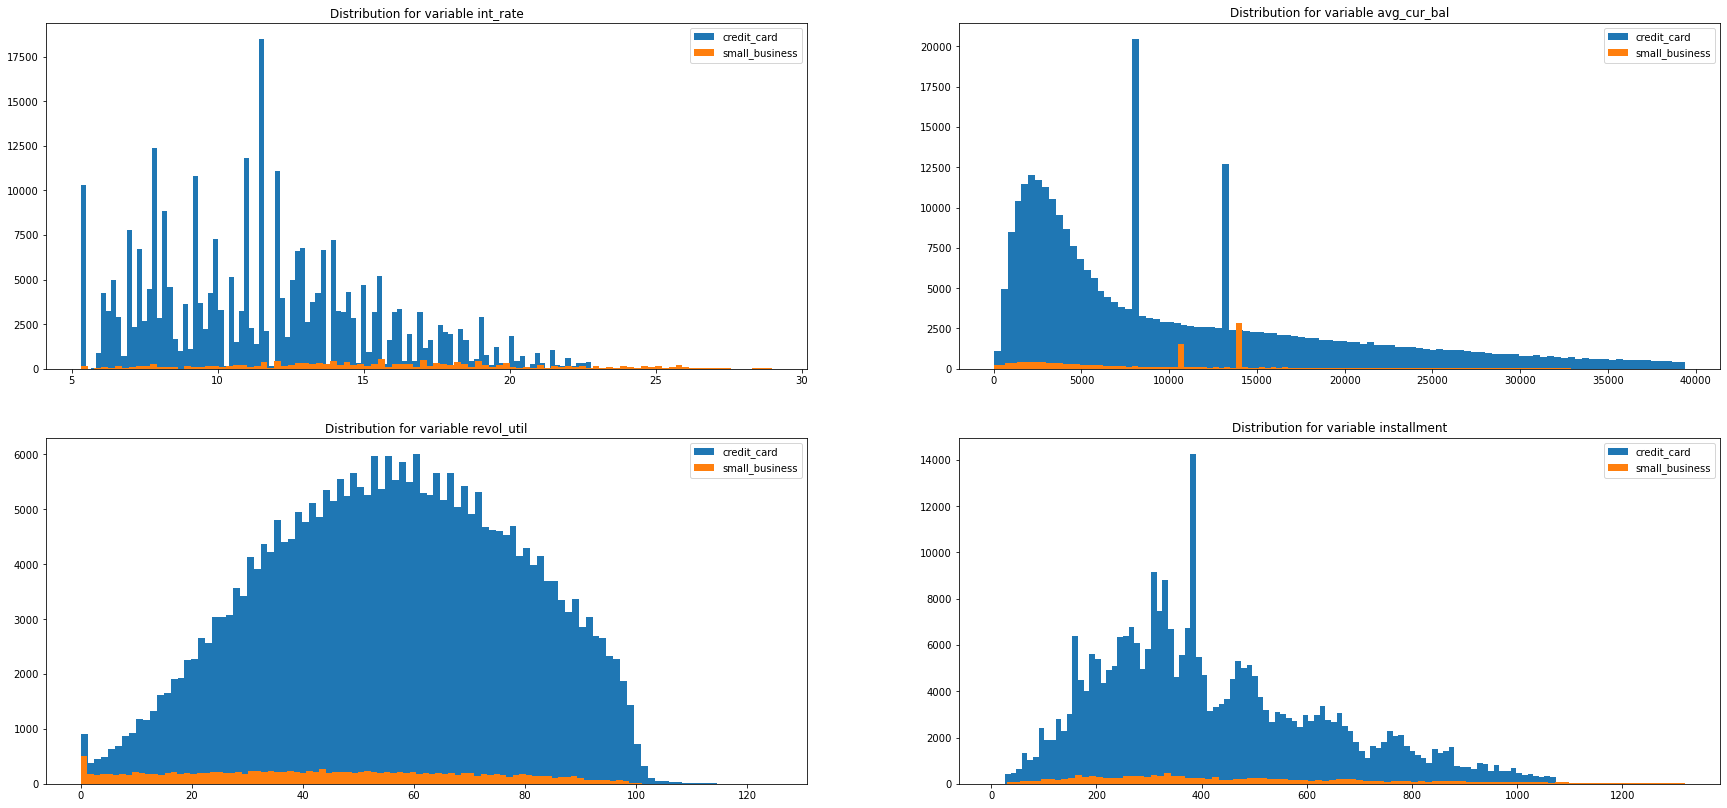

In [406]:
fig, ax = plt.subplots(2, 2, figsize=(30, 14)) # create a size and define the number + positions for subplots on the window

for i, j, feature in zip(i, j, features):
    ax[i, j].hist(credit_card[feature], bins=100, cumulative=False, histtype='stepfilled', label="credit_card")
    ax[i, j].hist(small_business[feature], bins=100, cumulative=False, histtype='stepfilled', label = "small_business")
    ax[i, j].title.set_text('Distribution for variable {}'.format(str(feature)))
    ax[i, j].legend()
    
plt.show()

In [407]:
credit_card.loc[:, features].describe().loc[['min', 'max', 'mean', '50%'], :].round(2)

,int_rate,avg_cur_bal,revol_util,installment
min,5.31,0.00,0.00,4.93
max,22.78,39419.00,124.50,1073.14
mean,11.54,10330.68,55.77,422.36
50%,11.47,7916.00,56.20,383.91


In [408]:
small_business.loc[:, features].describe().loc[['min', 'max', 'mean', '50%'], :].round(2)

,int_rate,avg_cur_bal,revol_util,installment
min,5.31,0.00,0.00,16.25
max,28.99,32872.00,116.10,1320.00
mean,15.80,10020.51,44.12,491.39
50%,15.61,10575.25,43.40,421.01


In [409]:
# correlation plot
credit_card.name  = 'credit card dataset'
small_business.name = 'small business dataset'

In [410]:
def corr_heatmap(df):
    mask = np.triu(np.ones_like(df.corr(), dtype=np.bool)) # matrix with ones on the lowest triangle
    df_corr = df.corr()
    df_corr[np.abs(df_corr)<.3] = None # filter out correlations that are under the 0.3

    plt.figure(figsize=(16, 6))
    heatmap = sns.heatmap(df_corr, mask=mask, vmin=-1, vmax=1, annot=True)
    heatmap.set_title(f'Correlation Heatmap of {df.name}', fontdict={'fontsize':16}, pad=12) # add title

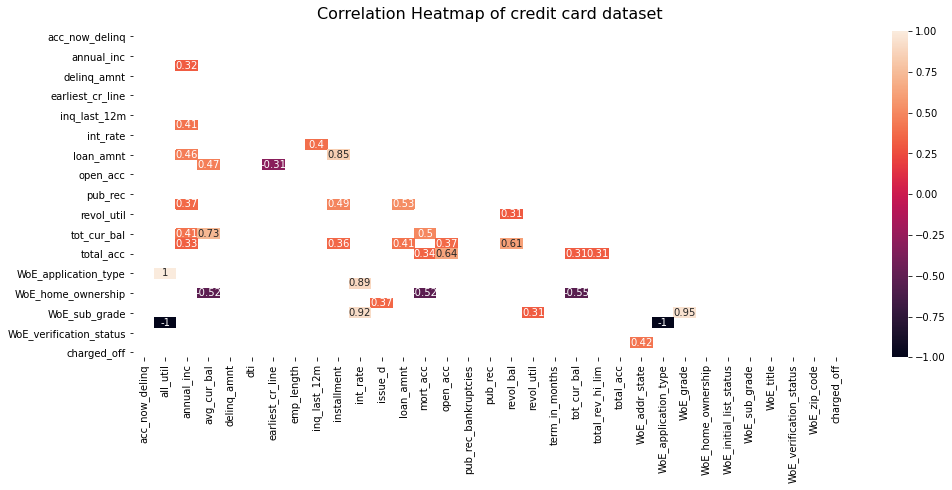

In [411]:
corr_heatmap(credit_card)

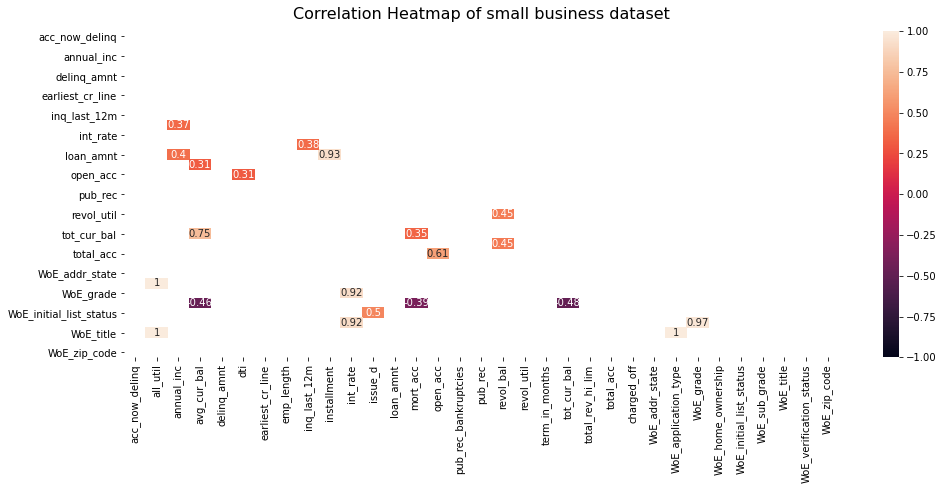

In [412]:
corr_heatmap(small_business)

# Defining models for benchmarking

In [415]:
def model(df1, df2):

    y_pred_train, y_probas_train, y_pred, y_probas = {}, {}, {}, {}
    
    # Separate the target variable and rest of the variables of both dataframes and set train test data
    X_train, y_train = df1.loc[:, df1.columns != 'charged_off'], df1.loc[:, 'charged_off']
    X_test, y_test = df2.loc[:, df2.columns != 'charged_off'], df2.loc[:, 'charged_off']
    
    dump = (X_train, y_train, X_test, y_test)    
    pickle.dump(dump, open('initial_values.pkl', 'wb'))
    
    # scale training set
    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train)).copy()
    X_train_scaled.columns = X_train.columns
    
    # scale test set
    X_test_scaled = pd.DataFrame(scaler.transform(X_test)).copy()
    X_test_scaled.columns = X_test.columns
           
    # Dmatrix for XGBoost 
    data_dmatrix = xgb.DMatrix(data = X_train_scaled, label = y_train)
    
    param_set_xgb = {
        'colsample_bytree': 0.3,
        'learning_rate': 0.1,
        'use_label_encoder': False,
        'max_depth': 5,
        'alpha': 10,
        'n_estimators': 10,
        'nthread': 4,
        'subsample': 1.0,
        'min_child_weight': 3
    }
    
    param_cv_xgb = {
        'nfold': 5,
        'num_boost_round': 100,
        'early_stopping_rounds': 50,
        'metrics': ["logloss", "error","auc"],
        'as_pandas': True,
        'seed': 123
    }    
        
    # xgboost
    xgboost = xgb.XGBClassifier(**param_set_xgb)

    # k-fold Cross Validation using XGBoost
    
    params = xgboost.get_xgb_params()
    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, **param_cv_xgb)
    xgboost.set_params(n_estimators=cv_results.shape[0])
    xgboost.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)], eval_metric=["logloss", "error", "auc"], verbose=False)    
    
    y_pred_train['y_pred_train_xgb'] = xgboost.predict(X_train_scaled)
    y_probas_train['y_probas_train_xgb'] = xgboost.predict_proba(X_train_scaled)
    
    y_pred['y_pred_xgb'] = xgboost.predict(X_test_scaled)
    y_probas['y_probas_xgb'] = xgboost.predict_proba(X_test_scaled)
      
    # adaboost
    adaboost = AdaBoostClassifier(n_estimators=100, random_state=0, learning_rate=0.2)
    #classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=200)   
    #adaboost.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)], eval_metric=["logloss", "error", "auc"], verbose=False)    
    
    adaboost.fit(X_train_scaled, y_train)       


    y_pred_train['y_pred_train_adb'] = adaboost.predict(X_train_scaled)
    y_probas_train['y_probas_train_adb'] = adaboost.predict_proba(X_train_scaled)
    
    y_pred['y_pred_adb'] = adaboost.predict(X_test_scaled)
    y_probas['y_probas_adb'] = adaboost.predict_proba(X_test_scaled)
        
    dump = (y_pred_train, y_probas_train, y_pred, y_probas)    
    pickle.dump(dump, open('predictions.pkl', 'wb'))
    
    # save models to disk
    pickle.dump(xgboost, open('xgb_clf.sav', 'wb'))
    pickle.dump(adaboost, open('adb_clf.sav', 'wb'))

    return y_train, y_test


In [416]:
y_train, y_test = model(credit_card, small_business)

In [417]:
y_pred_train, y_probas_train, y_pred, y_probas = pickle.load(open('predictions.pkl', 'rb'))
y_pred_train

{'y_pred_train_xgb': array([0, 0, 0, ..., 0, 0, 0]),
 'y_pred_train_adb': array([0, 0, 0, ..., 0, 0, 0])}

In [418]:
y_probas['y_probas_adb'][:,1]

array([0.48989648, 0.49194111, 0.49418605, ..., 0.49956904, 0.48900263,
       0.4915645 ])

In [419]:
y_probas_train['y_probas_train_adb']

array([[0.53394338, 0.46605662],
       [0.52134754, 0.47865246],
       [0.53396434, 0.46603566],
       ...,
       [0.52246955, 0.47753045],
       [0.51510687, 0.48489313],
       [0.50887559, 0.49112441]])

In [420]:
def model_report(y_pred_train, y_train, y_pred, y_test, y_probas_train, y_probas):
    
    #Print model report for train set:
    print ("\nModel Report for training data:")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_train, y_pred_train))
    print ("F1-score : %.4g" % metrics.f1_score(y_train, y_pred_train))
    print ("Recall : %.4g" % metrics.recall_score(y_train, y_pred_train))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_probas_train[:,1]))

    
    #Print model report for test set:
    print ("\nModel Report for test set:")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_test, y_pred))
    print ("F1-score : %.4g" % metrics.f1_score(y_test, y_pred))
    print ("Recall : %.4g" % metrics.recall_score(y_test, y_pred))
    print ("AUC Score (Test): %f" % metrics.roc_auc_score(y_test, y_probas[:,1]))

In [421]:
model_report(y_pred_train['y_pred_train_adb'], y_train, y_pred['y_pred_adb'], y_test, 
             y_probas_train['y_probas_train_adb'], y_probas['y_probas_adb'])


Model Report for training data:
Accuracy : 0.8313
F1-score : 0.01985
Recall : 0.01009
AUC Score (Train): 0.724087

Model Report for test set:
Accuracy : 0.707
F1-score : 0.0892
Recall : 0.04831
AUC Score (Test): 0.654890


In [422]:
model_report(y_pred_train['y_pred_train_xgb'], y_train, y_pred['y_pred_xgb'], y_test, 
             y_probas_train['y_probas_train_xgb'], y_probas['y_probas_xgb'])


Model Report for training data:
Accuracy : 0.8338
F1-score : 0.09687
Recall : 0.05266
AUC Score (Train): 0.740524

Model Report for test set:
Accuracy : 0.7026
F1-score : 0.289
Recall : 0.2035
AUC Score (Test): 0.664236


In [423]:
X_train, y_train, X_test, y_test = pickle.load(open('initial_values.pkl', 'rb'))

# load models from disk
xgbst = pickle.load(open('xgb_clf.sav', 'rb'))
xgbst.name = "XGBoostClassifier"

adb = pickle.load(open('adb_clf.sav', 'rb'))
adb.name = "AdaBoost"

xgbst.feature_importances_

array([0.        , 0.        , 0.01250466, 0.02091791, 0.        ,
       0.01922964, 0.00547514, 0.01742576, 0.0064385 , 0.01660438,
       0.08484026, 0.03933621, 0.0229327 , 0.00919373, 0.00837673,
       0.        , 0.        , 0.00605046, 0.00872912, 0.        ,
       0.00655703, 0.00557226, 0.0039916 , 0.00561182, 0.        ,
       0.44023687, 0.02753223, 0.01243938, 0.18250407, 0.        ,
       0.01810336, 0.01939618], dtype=float32)

In [424]:
# Feature Importance
def feature_importance(model, X_train):
    plt.rcParams['figure.figsize'] = [10, 10]
    features = X_train.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.title(f'Feature Importances of {model.name}')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')    
    plt.show() 

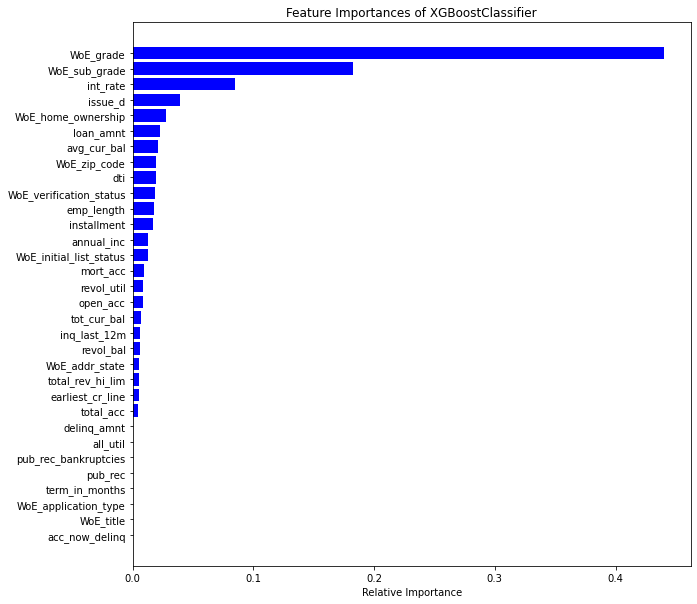

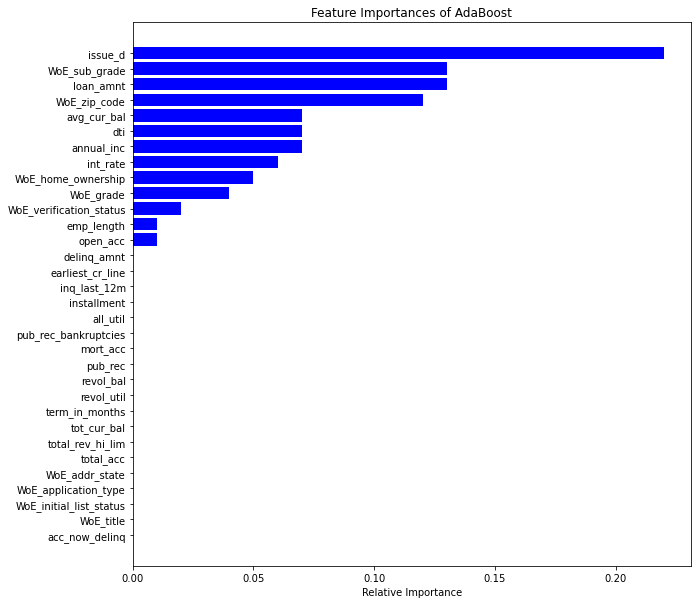

In [425]:
feature_importance(xgbst, X_train)
feature_importance(adb, X_train)

In [426]:
def roc_curve(model, y_train, y_probas_train, y_test, y_probas):
    plt.rcParams['figure.figsize'] = [5, 5]
    # ROC curve plot for train set
    skplt.metrics.plot_roc(y_train, y_probas_train, title = f'ROC Curve {model.name} for training set',
                           plot_micro = False, plot_macro = False, classes_to_plot = [1], cmap='inferno')
    
    # ROC curve plot for test set
    skplt.metrics.plot_roc(y_test, y_probas, title = f'ROC Curve {model.name} for test set',
                           plot_micro = False, plot_macro = False, classes_to_plot = [1], cmap='inferno')
    plt.show()

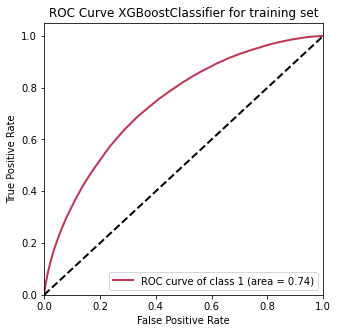

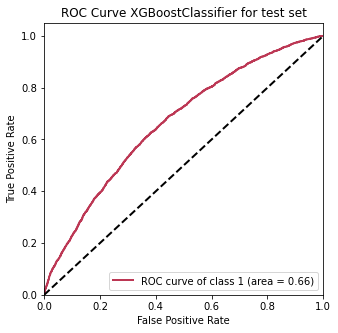

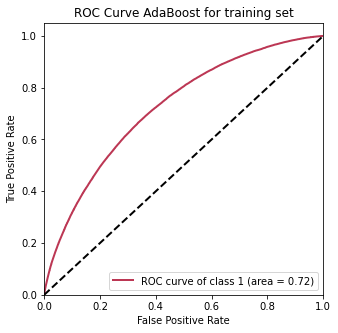

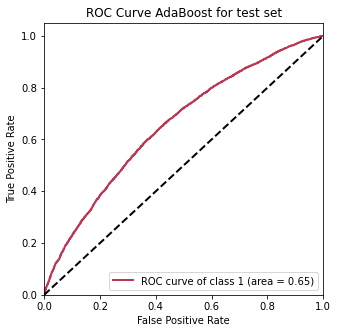

In [427]:
roc_curve(xgbst, y_train, y_probas_train['y_probas_train_xgb'], y_test, y_probas['y_probas_xgb'])
roc_curve(adb, y_train, y_probas_train['y_probas_train_adb'], y_test, y_probas['y_probas_adb'])

In [428]:
# additional graphs

metrics = ['logloss', 'error']

def log_loss_or_error(model, metric):

    results = model.evals_result()
    epochs = len(results['validation_0'][metric])
    x_axis = range(0, epochs)
    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0'][metric], label='Train')
    ax.plot(x_axis, results['validation_1'][metric], label='Test')
    ax.legend()
    plt.ylabel(f'{metric}')
    plt.title(f'Plot for {model.name} model and its {metric} metric')
    plt.show()


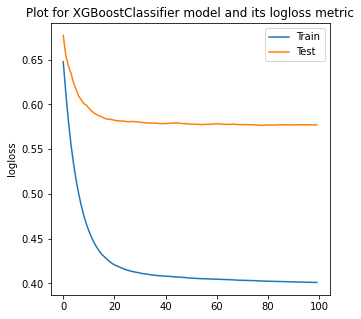

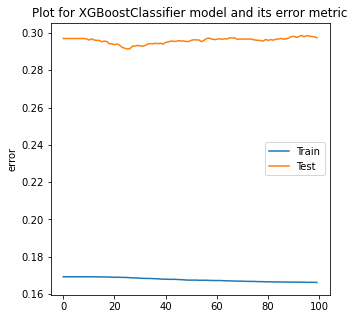

In [429]:
for metric in metrics:
    log_loss_or_error(xgbst, metric)

# Application of Transfer Learning techniques

## 1. TL technique 1

## 2. TrAdaBoost algorithm

In [187]:
credit_card.describe().loc[['min', 'max'], :].round()

,acc_now_delinq,all_util,annual_inc,avg_cur_bal,delinq_amnt,dti,earliest_cr_line,emp_length,inq_last_12m,installment,...,WoE_addr_state,WoE_application_type,WoE_grade,WoE_home_ownership,WoE_initial_list_status,WoE_sub_grade,WoE_title,WoE_verification_status,WoE_zip_code,charged_off
min,0.0,58.0,100.0,0.0,0.0,0.0,3.418848e+17,1.0,0.0,5.0,...,-2.0,-2.0,-3.0,-2.0,-2.0,-3.0,-2.0,-2.0,-2.0,0.0
max,0.0,58.0,159700.0,39419.0,0.0,42.0,1.441066e+18,10.0,2.0,1073.0,...,-1.0,-2.0,-0.0,-1.0,-2.0,0.0,-2.0,-1.0,-1.0,1.0


In [188]:
small_business.describe().loc[['min', 'max'], :].round()

,acc_now_delinq,all_util,annual_inc,avg_cur_bal,delinq_amnt,dti,earliest_cr_line,emp_length,inq_last_12m,installment,...,charged_off,WoE_addr_state,WoE_application_type,WoE_grade,WoE_home_ownership,WoE_initial_list_status,WoE_sub_grade,WoE_title,WoE_verification_status,WoE_zip_code
min,0.0,53.0,1200.0,0.0,0.0,0.0,3.813696e+17,1.0,0.0,16.0,...,0.0,-1.0,-1.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0,-2.0
max,0.0,53.0,195000.0,32872.0,0.0,39.0,1.433117e+18,10.0,2.0,1320.0,...,1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0


In [189]:
# separate dataset to the same and different
def df_same_diff(source_df, target_df):
    
    min_max = target_df.describe().loc[['min', 'max'], :]
    out_of_range_idx = []

    for row in source_df.index:
        for column in source_df.columns:
            if source_df.loc[row, column] <= min_max.loc['min', column] or source_df.loc[row, column] >= min_max.loc['max', column]: #out of range
                out_of_range_idx.append(row)
    
    values, counts = np.unique(out_of_range_idx, return_counts=True)
    df = pd.DataFrame(values, counts).reset_index()
    df['idx'] = source_df.index.copy()
    df.loc[:, 'dummy'] = df.loc[:,'index'].apply(lambda x: 1 if x > 13 else 0)
    indices = np.array(df[df['dummy'] == 1]['idx'])
    
    df_diff = source_df.loc[indices, :].copy()
    df_same = source_df.loc[~source_df.index.isin(indices)].copy()
    
    return df_diff, df_same

In [190]:
df_diff, df_same = df_same_diff(credit_card, small_business)
df_same

,acc_now_delinq,all_util,annual_inc,avg_cur_bal,delinq_amnt,dti,earliest_cr_line,emp_length,inq_last_12m,installment,...,WoE_addr_state,WoE_application_type,WoE_grade,WoE_home_ownership,WoE_initial_list_status,WoE_sub_grade,WoE_title,WoE_verification_status,WoE_zip_code,charged_off
97,0.0,58.438338,14688.0,1440.0,0.0,14.79,1046476800000000000,5.823349,1.0,152.77,...,-1.441641,-1.592628,-1.204595,-1.409480,-1.566947,-1.415772,-1.550972,-1.372617,-1.324284,0
122,0.0,58.438338,35000.0,3194.0,0.0,33.54,783648000000000000,4.000000,1.0,315.63,...,-1.364357,-1.592628,-1.882248,-1.531861,-1.566947,-2.175438,-1.550972,-1.895562,-1.396657,0
167,0.0,58.438338,24000.0,13041.0,0.0,18.05,733622400000000000,5.823349,1.0,102.96,...,-1.441641,-1.592628,-1.882248,-1.783396,-1.566947,-1.910610,-1.550972,-1.895562,-1.431145,1
264,0.0,58.438338,85000.0,13224.0,0.0,35.79,1086048000000000000,9.000000,1.0,585.70,...,-1.578951,-1.592628,-0.415074,-1.783396,-1.566947,-0.416424,-1.550972,-1.372617,-1.386294,1
359,0.0,58.438338,78000.0,20157.0,0.0,12.58,823132800000000000,7.000000,1.0,354.30,...,-1.421049,-1.592628,-1.882248,-1.783396,-1.566947,-2.059558,-1.550972,-1.895562,-1.298524,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516753,0.0,58.438338,80000.0,2049.0,0.0,14.87,1038700800000000000,9.000000,1.0,326.42,...,-1.540407,-1.592628,-1.882248,-1.409480,-1.628451,-1.607396,-1.550972,-1.895562,-1.571437,0
516765,0.0,58.438338,150000.0,3480.0,0.0,6.01,546825600000000000,9.000000,1.0,476.93,...,-1.557021,-1.592628,-1.882248,-1.783396,-1.628451,-2.175438,-1.550972,-1.895562,-1.545534,1
516937,0.0,58.438338,54900.0,16045.0,0.0,28.41,1199145600000000000,2.000000,1.0,241.87,...,-1.578951,-1.592628,-1.204595,-1.783396,-1.628451,-1.415772,-1.550972,-1.895562,-1.603102,1
516944,0.0,58.438338,79000.0,20584.0,0.0,6.43,975628800000000000,3.000000,1.0,332.06,...,-1.524795,-1.592628,-1.882248,-1.783396,-1.628451,-2.175438,-1.550972,-1.895562,-1.570508,0


In [209]:
def tradaboost_func(df_diff, df_same, df_test):
    N = 10
    n = df_diff.shape[0]
    m = df_same.shape[0]
    #np.random.seed(123)
    #weights = np.random.rand(n + m)
    weights = np.repeat(0.5, n + m) # for example
    df_train = pd.concat([df_diff.loc[:, df_diff.columns != 'charged_off'], df_same.loc[:, df_same.columns != 'charged_off']], ignore_index=True)
    y_train = np.concatenate([df_diff['charged_off'], df_same['charged_off']], axis=None)
    
    X_train, y_train = df_train, y_train
    X_test, y_test = df_test.loc[:, df_test.columns != 'charged_off'], df_test['charged_off']
        
    # scale training set
    #scaler = MinMaxScaler()
    #X_train_scaled = scaler.fit_transform(X_train)
    
    # scale test set
    #X_test_scaled = scaler.transform(X_test)
    

    beta_t_N = []
    y_pred_N = [] 
    
    for i in range(N):
        
        def fnc_for_weight():
        
            nonlocal weights
            
        # 1.
        p = weights/sum(weights)

        # 2. 
        clf = AdaBoostClassifier(n_estimators=100, random_state=0, learning_rate=0.2)

        clf.fit(X_train, y_train, sample_weight = p)
        
        # Make predictions on the training set
        y_pred_train = clf.predict(X_train)
        y_probas_train = clf.predict_proba(X_train)

        # Make predictions on the test set
        y_pred = clf.predict(X_test)
        y_probas = clf.predict_proba(X_test)
        
        y_pred_N.append(y_pred)

        # 3. 
        #error_H = sum(p[n:(n+m)] *  np.abs(y_pred[n:(n+m)] - y_true[n:(n+m)]))
        error_H = sum(weights[n:(n+m)] *  np.abs(y_pred_train[n:(n+m)] - y_train[n:(n+m)]) / sum(weights[n:(n+m)]))


        # 4.
        beta = 1 / (1 + np.sqrt(2 * np.log(n / N)))
        beta_t = error_H / (1 - error_H)
            
        beta_t_N.append(beta_t)
            
        if error_H >= 0.5: 
            print('Error of Hypothesis on the sourse data with the same difference cannot be equeal or greater than 0.5.')
        
        break
        
        # 5.
        weights[0:n] = weights[0:n] * beta ** (np.abs(y_pred_train[0:n] - y_train[0:n]))
        weights[n:(n+m)] = weights[n:(n+m)] * beta_t ** ( - np.abs(y_pred_train[n:(n+m)] - y_train[n:(n+m)]))
    
        fnc_for_weight()
    
    # output:
    output = pd.DataFrame(y_pred_N)
    output_slice = output.iloc[int(np.round(N/2)):N].copy()
    beta_t_slice = beta_t_N[int(np.round(N/2)):N].copy()
    
    output_slice.loc['condition1',:] = output_slice.apply(lambda x: np.prod(beta_t_slice ** - x), axis = 0)
    condition2 = np.prod(beta_t_slice ** np.array(-1/2)) #unsupported operand type(s) for ** or pow(): 'list' and 'int'
    output_slice.loc['output', :] = output_slice.loc['condition1',:].apply(lambda x: 1 if x >= condition2 else 0)
        
    return y_pred_train, y_train, output_slice.loc['output', :], y_test, y_probas_train, y_probas

In [210]:
y_pred_tr, y_tr, y_pr, y_t, y_pr_tr, y_pr = tradaboost_func(df_diff, df_same, small_business)

In [211]:
model_report(y_pred_tr, y_tr, y_pr, y_t, y_pr_tr, y_pr)


Model Report for training data:
Accuracy : 0.8313
F1-score : 0.01985
Recall : 0.01009

Model Report for test set:
Accuracy : 0.297
F1-score : 0.458
Recall : 1


# Automated EDA with pandas_profiling

In [ ]:
pandas_profiling.ProfileReport(credit_card)

In [ ]:
pandas_profiling.ProfileReport(small_business)